# Линейная регрессия
__Суммарное количество баллов: 10__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[ML][MS][HW03] <ФИ>`, где вместо `<ФИ>` указаны фамилия и имя__

In [1]:
from sklearn.datasets import make_blobs, make_moons
from sklearn.model_selection import train_test_split
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy

In [2]:
def read_data(path="boston.csv"):
    dataframe = np.genfromtxt(path, delimiter=",", skip_header=15)
    np.random.seed(42)
    np.random.shuffle(dataframe)
    X = dataframe[:, :-1]
    y = dataframe[:, -1]
    return X, y

In [3]:
def generate_synthetic(size:int, dim=6, noise=0.1):
    X = np.random.randn(size, dim)
    w = np.random.randn(dim + 1)
    noise = noise * np.random.randn(size)
    y = X.dot(w[1:]) + w[0] + noise
    return X, y

### Задание 1 (1 балл)
Для начала нужно понять, какую метрику для ошибки будем использовать. В нашем случае нам подойдет стандартная метрика MSE. Также чтобы оценить качество модели нам понадобится метрика $R^2$. Реализуйте обе эти метрики.

In [4]:
def mse(y_true: np.ndarray, y_predicted: np.ndarray):
    e = y_predicted - y_true
    return 1 / len(e) * e @ e


def r2(y_true: np.ndarray, y_predicted: np.ndarray):
    y_true_mean = np.mean(y_true)
    SS_tot = (y_true - y_true_mean) @ (y_true - y_true_mean)
    SS_res = (y_true - y_predicted) @ (y_true - y_predicted)
    return 1 - SS_res / SS_tot

### Задание 2 (3 балла)
Теперь реализуем линейную регрессию при помощи явного решения задачи минимизации. 

#### Методы
`fit(X, y)` - решает задачу минимизации $\arg\min_{w, b}\sum ((w\cdot x + b) - y)^2$. 

`predict(X)` - строит предсказание `y` для объектов из `X`.

In [5]:
class NormalLR:
    def __init__(self):
        pass

    def fit(self, X: np.ndarray, y: np.ndarray):
        b = np.ones_like(y).reshape(-1, 1)
        _X = np.hstack((X, b))

        self.w = np.linalg.inv(_X.T @ _X) @ _X.T @ y

    def predict(self, X: np.ndarray) -> np.ndarray:
        b = np.ones(X.shape[0]).reshape(-1, 1)
        _X = np.hstack((X, b))
        return _X @ self.w

In [6]:
X, y = generate_synthetic(1024)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [7]:
regr = NormalLR()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
print(f"MSE: {mse(y_test, y_pred)}, R2: {r2(y_test, y_pred)}")

MSE: 0.009854867556191622, R2: 0.996485652716804


### Задание 3 (2 балла)
Теперь реализуем линейную регрессию с использованием градиентного спуска с larning rate `alpha` в течении `iterations` итераций. В задании необходимо использовать регуляризацию Лассо с коэффициентом `l`.

#### Методы
`fit(X, y)` - приближает решение задачи минимизации $\arg\min_{w, b}\sum ((w\cdot x + b) - y)^2$ при помощи градиентного спуска. 


`predict(X)` - строит предсказание `y` для объектов из `X`.

In [8]:
class GradientLR:
    def __init__(self, alpha: float, iterations=10000, l=0.001):
        self.alpha = alpha
        self.iterations = iterations
        self.l = l

    def fit(self, X: np.ndarray, y: np.ndarray):
        b = np.ones_like(y).reshape(-1, 1)
        _X = np.hstack((X, b))
        n = _X.shape[1]
        w = np.zeros(_X.shape[1])
        w = np.random.uniform(-1 / np.sqrt(n), 1 / np.sqrt(n), size=n)
        self.w = self.optimize(_X, y, w, tol=1e-8, max_iter=self.iterations)

    def stop_criterion(self, x0_grad, x_grad, tol):
        x_grad_norm = np.linalg.norm(x_grad)
        x0_grad_norm = np.linalg.norm(x0_grad)
        rk = x_grad_norm ** 2 / x0_grad_norm ** 2
        return rk < tol

    def optimize(self, X, y, x0, tol=1e-8, max_iter=int(1e4)) -> np.ndarray:
        grad = lambda w: 1 / X.shape[0] * (2 * X.T @ X @ w - 2 * X.T @ y) + self.l * np.sign(w)
        x0_grad = grad(x0)
        x_k = x0.copy()
        for i in range(max_iter):
            xk_grad = grad(x_k)
            p_k = -xk_grad

            alpha = self.alpha

            x_k = x_k + alpha * p_k

            if self.stop_criterion(x0_grad, xk_grad, tol):
                break
        return x_k

    def predict(self, X: np.ndarray):
        b = np.ones(X.shape[0]).reshape(-1, 1)
        _X = np.hstack((X, b))
        return _X @ self.w

In [9]:
def build_plot(X_train, y_train, X_test, y_test):
    xs = np.arange(20, 40, 1)
    errors = []
    for x in xs:
        regr = GradientLR(0.01, iterations=10000, l=x)
        regr.fit(X_train, y_train)
        errors.append(mse(y_test, regr.predict(X_test)))
    plt.figure(figsize=(9, 4))
    plt.xlim(xs[0], xs[-1])
    plt.grid()
    plt.plot(xs, errors)
    plt.show()

In [10]:
X, y = generate_synthetic(1024)
X, X_val, y, y_val = train_test_split(X, y, train_size=0.9, shuffle=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True)

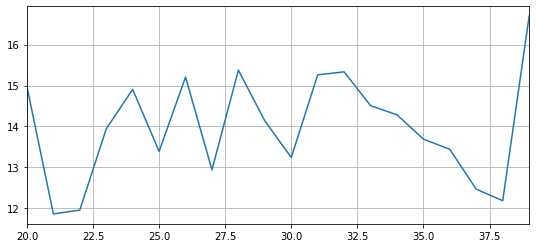

In [11]:
build_plot(X_train, y_train, X_val, y_val)

In [12]:
regr = GradientLR(0.1, iterations=10000)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
print(f"MSE: {mse(y_test, y_pred)}, R2: {r2(y_test, y_pred)}")

MSE: 0.009404349432720617, R2: 0.9992718257420719


### Задание 4 (2 балла)
Протесируйте оба метода на данных `boston.csv`, для градиентного спуска постройте график зависимости ошибки от коэффициента регуляризации. 

In [13]:
from sklearn.preprocessing import MinMaxScaler

X, y = read_data()
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, shuffle=False)
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)

In [14]:
regr = NormalLR()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_val)
print(f"MSE: {mse(y_val, y_pred)}, R2: {r2(y_val, y_pred)}")

MSE: 22266311.080837082, R2: 0.6872797475661024


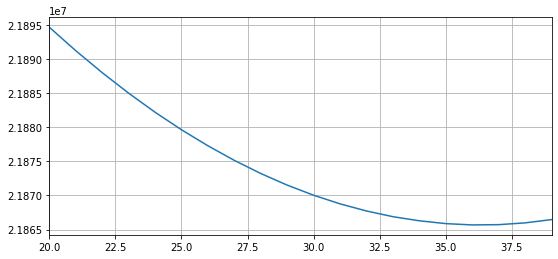

In [15]:
build_plot(X_train, y_train, X_val, y_val)

In [16]:
regr = GradientLR(0.01, l=36, iterations=10000)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_val)
print(f"MSE: {mse(y_val, y_pred)}, R2: {r2(y_val, y_pred)}")

MSE: 21865684.294682976, R2: 0.6929063692926676


### Задание 5 (2 балла)
Проинтерпритируйте полученные результаты. Опишите влияние каждого признака на результат предсказания.

Выпишем, названия фичей

1. crim     per capita crime rate by town
2. zn       proportion of residential land zoned for lots over 25,000 sq.ft.
3. indus    proportion of non-retail business acres per town
4. chas     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
5. nox      nitric oxides concentration (parts per 10 million)
6. rm       average number of rooms per dwelling
7. age      proportion of owner-occupied units built prior to 1940
8. dis      weighted distances to five Boston employment centres
9. rad      index of accessibility to radial highways
10. tax      full-value property-tax rate per 10,000 usd
11. ptratio  pupil-teacher ratio by town
12. b        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
13. lstat    % lower status of the population
14. medv     median value of owner-occupied homes in usd

In [17]:
for i in range(len(regr.w)):
    print(f'{i + 1}: {regr.w[i]}')

1: -3671.102907678526
2: 3065.2925430589603
3: -190.35622236132656
4: 2246.950242954965
5: -3802.1238234080342
6: 23587.37809763814
7: 563.7145531086062
8: -9282.42666166585
9: 4169.562835030178
10: -4928.54415888396
11: -7084.3449597959325
12: 4669.332700135694
13: -18119.524701430313
14: 19301.034193953987


Посмотрев на веса, мы можем сделать вывод, что больше всего увеличивают цену 14 и 6 фичи, средняя цена частной домов и среднее количество комнат в доме, соответственно.

Сильнее всего понижают стоимость жилья 13 и 8, процент малого класса и взвешенное растояние до 5 основных бизнес центров бостона, соответственно.